# Project II: Economic Growth 

In [1]:
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
import numpy.linalg as la
from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures
import plotly.express as px

%load_ext autoreload
%autoreload 2

# Import the py-file
import Project_2_Jens_Freja_Annalivia as a2

## Read data 

In [2]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() 
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


## Collections of variables

In [ ]:
# Categories of variables
vv_institutions = ['marketref', 'polity', 'legor_fr', 'legor_uk', 'dem', 'demreg', 'ln_yst'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['gdp_pc_initial', 'lpop_initial'] 
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] 
vv_econ = ['investment_rate', 'pop_growth']

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources,
          'econ':vv_econ,
          'educ':vv_educ
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]

#Make constant
dat['constant'] = np.ones((dat.shape[0],))

## Our selection of variables

In [4]:
#Remove all countries with missing values in gdp_growth or lgdp_initial
dat = dat.dropna(subset=['gdp_growth', 'lgdp_initial'])
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 102 rows (countries) and 86 columns (variables).


In [5]:
#Keep only the variables we want to work with 
vv_selected = ['code', 'gdp_growth', 'lgdp_initial'] + vv_all['institutions'] + vv_all['resources'] + vv_all['educ'] + vv_all['historical'] + vv_all['econ'] + ['constant']
dat_reduced = dat[vv_selected].copy()
print(f'The reduced data contains {dat_reduced.shape[0]} rows (countries) and {dat_reduced.shape[1]} columns (variables).')

The reduced data contains 102 rows (countries) and 22 columns (variables).


In [6]:
#Print the names of the variables in the reduced data
print('Variables in the reduced data:')
for var in dat_reduced.columns:
    print(f'- {var}: {lbl_all.get(var, "No label available")}') 

Variables in the reduced data:
- code: World Bank country code
- gdp_growth: Annual growth in GDP per capita, 1970-2020
- lgdp_initial: GDP per capita in 1970 (log)
- marketref: Index of market reforms (1960)
- polity: Polity (measure of democracy)
- legor_fr: French legal origin dummy
- legor_uk: British legal origin dummy
- dem: Democracy measure by ANRR
- demreg: Average democracy in the region*initial regime (leaving own country out)
- ln_yst: Log [Neolithic transition timing]
- oilres: oil reserves 
- goldm: Natural minerals: gold
- iron: Natural mineral: iron
- silv: Natural mineral: silver
- zinc: Natural mineral: zinc
- ls_bl: Percentage of population with at most secondary education (Barro-Lee)
- lh_bl: Percentage of population with tertiary education (Barro-Lee)
- gdp_pc_initial: GDP per capita in 1970
- lpop_initial: Population in 1970 (log)
- investment_rate: Capital formation (% of GDP per year, avg. of available years 1970-2020)
- pop_growth: Annual growth in population, 

In [7]:
#Make index based on country code
all_vars = vv_selected.copy()
all_vars.remove('code')
I = dat_reduced[all_vars].notnull().all(1)

# Liste over lande (uden at ændre index)
countries_with_all_vars = dat_reduced.loc[I, 'code'].tolist()
print(f'The number of countries where all variables are available is {I.sum()}.')
print('Countries with all variables available:', countries_with_all_vars)

The number of countries where all variables are available is 71.
Countries with all variables available: ['ARG', 'AUS', 'AUT', 'BEL', 'BEN', 'BOL', 'BRA', 'CAF', 'CHL', 'CHN', 'CIV', 'CMR', 'COL', 'CRI', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'FIN', 'FRA', 'GAB', 'GBR', 'GHA', 'GMB', 'GRC', 'GTM', 'GUY', 'HND', 'IDN', 'IND', 'IRL', 'IRN', 'ITA', 'JAM', 'KEN', 'KOR', 'LKA', 'MAR', 'MEX', 'MLI', 'MMR', 'MRT', 'MYS', 'NER', 'NIC', 'NLD', 'NOR', 'NPL', 'PAK', 'PAN', 'PER', 'PHL', 'PRT', 'PRY', 'RWA', 'SAU', 'SEN', 'SLE', 'SLV', 'SWE', 'TGO', 'THA', 'TUN', 'TUR', 'URY', 'USA', 'ZAF', 'ZMB', 'ZWE']


In [8]:
#Now remove countries with any missing values in the selected variables
dat_reduced = dat_reduced.dropna()
print(f'The reduced data contains {dat_reduced.shape[0]} rows (countries) and {dat_reduced.shape[1]} columns (variables).')

The reduced data contains 71 rows (countries) and 22 columns (variables).


## Simple OLS

In [18]:
#Make list of all explanatory variables (exclude gdp_growth)
xs = dat_reduced.columns.tolist()
xs.remove('gdp_growth')
xs.remove('code')

# extract data
X = dat_reduced.loc[I, xs].values
y = dat_reduced.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100.

# check the rank condition
K = X.shape[1]
print(f'Number of explanatory variables: {K}')

# Compute the OLS estimator
betas = np.linalg.inv(X.T @ X) @ X.T @ y

#Format output
print(f'Mean y = {y.mean(): 5.2f}% growth per year')
pd.DataFrame({'β': betas[:,0]}, index=xs).round(3)

Number of explanatory variables: 20
Mean y =  1.56% growth per year


,β
lgdp_initial,-0.522
marketref,-0.003
polity,0.006
legor_fr,-0.852
legor_uk,-1.007
dem,0.684
demreg,-0.724
ln_yst,0.309
oilres,0.000
goldm,-0.031


## Prepare data for PDL

In [12]:
#Define d, Z and X
d = dat_reduced.loc[I,'lgdp_initial'].values.reshape((-1,1))

# Definer dine base feature-navne (før interaktioner)
base_features = dat_reduced.drop(columns=['gdp_growth', 'lgdp_initial', 'constant', 'code']).columns

# Opret polynomial transformer (uden konstant)
poly = PolynomialFeatures(degree=2, include_bias=False)

# Fit og transformer Z
Z = poly.fit_transform(dat_reduced.loc[I, base_features].values)

# Gem feature-navne
feature_names = poly.get_feature_names_out(base_features)
# Fjern interaktioner og kvadrerede led
main_feature_names = [name for name in feature_names if " " not in name and "^" not in name]

print("Antal regressorer:", len(feature_names))
print("Nogle af de første 30 feature-navne:", feature_names[:30])
print("Main feature names (uden interaktioner og kvadrerede led):", main_feature_names)

Antal regressorer: 189
Nogle af de første 30 feature-navne: ['marketref' 'polity' 'legor_fr' 'legor_uk' 'dem' 'demreg' 'ln_yst'
 'oilres' 'goldm' 'iron' 'silv' 'zinc' 'ls_bl' 'lh_bl' 'gdp_pc_initial'
 'lpop_initial' 'investment_rate' 'pop_growth' 'marketref^2'
 'marketref polity' 'marketref legor_fr' 'marketref legor_uk'
 'marketref dem' 'marketref demreg' 'marketref ln_yst' 'marketref oilres'
 'marketref goldm' 'marketref iron' 'marketref silv' 'marketref zinc']
Main feature names (uden interaktioner og kvadrerede led): ['marketref', 'polity', 'legor_fr', 'legor_uk', 'dem', 'demreg', 'ln_yst', 'oilres', 'goldm', 'iron', 'silv', 'zinc', 'ls_bl', 'lh_bl', 'gdp_pc_initial', 'lpop_initial', 'investment_rate', 'pop_growth']


In [13]:
# Construct X for post-double 
X = np.column_stack((d,Z))

#Redfine output 
g_LR = dat_reduced.loc[I,'gdp_growth'] * 100 #easier to read output when growth is in %
#Second stage regressor
dd = dat_reduced.loc[I, 'lgdp_initial']

# Find N
N = X.shape[0]
print(f'The number of observations is N={N}. The number of regressors is K={X.shape[1]}.')

The number of observations is N=71. The number of regressors is K=190.


In [14]:
#Get rid of constant columns in X, Z, and d
stds = np.std(X, axis=0)
nonconstant_cols = stds != 0
X = X[:, nonconstant_cols]
Z = Z[:, np.std(Z, axis=0) != 0]  
d = d[:, np.std(d, axis=0) != 0]  

print(f"Removed {(~nonconstant_cols).sum()} constant columns.")
print("Number of columns after cleaning:", X.shape[1])

# Standardize data  
X_stan = a2.standardize(X)
Z_stan = a2.standardize(Z)

print("Number of NaNs after standardization:", np.isnan(X_stan).sum())

Removed 1 constant columns.
Number of columns after cleaning: 189
Number of NaNs after standardization: 0


## PDL using CV

In [15]:
# Post-Double-Lasso with CV  
alpha_PDL, se_PDL, CI_low_PDL, CI_high_PDL = a2.post_double_lasso_analysis(Z_stan, dd, X_stan, g_LR, penalty_method='CV', feature_names=feature_names)

/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.980e-02, tolerance: 1.131e-02
  model = cd_fast.enet_coordinate_descent(
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.406e-02, tolerance: 1.017e-02
  model = cd_fast.enet_coordinate_descent(
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

The first-stage penalty is =  0.06
The second-stage penalty is =  0.058
The number of non-zero coefficients in the first stage is 20
Selected variables in the first stage:
['marketref', 'ls_bl', 'gdp_pc_initial', 'investment_rate', 'polity investment_rate', 'legor_fr ln_yst', 'legor_fr oilres', 'legor_fr silv', 'legor_fr ls_bl', 'legor_fr lpop_initial', 'legor_uk pop_growth', 'ln_yst goldm', 'ln_yst lh_bl', 'ln_yst gdp_pc_initial', 'goldm investment_rate', 'ls_bl investment_rate', 'gdp_pc_initial^2', 'gdp_pc_initial investment_rate', 'gdp_pc_initial pop_growth', 'lpop_initial investment_rate']
The number of non-zero coefficients in the second stage is = 17
Selected variables in the second stage:
['marketref', 'oilres', 'marketref legor_fr', 'marketref legor_uk', 'polity legor_uk', 'polity iron', 'polity silv', 'legor_fr zinc', 'legor_fr gdp_pc_initial', 'legor_uk pop_growth', 'demreg lpop_initial', 'ln_yst lpop_initial', 'ls_bl investment_rate', 'ls_bl pop_growth', 'lpop_initial invest

/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.146e-02, tolerance: 1.229e-02
  model = cd_fast.enet_coordinate_descent(


## PDL using BCCH-penalty

In [16]:
# Post-Double-Lasso with BCCH (function in py-file)
alpha_PDL, se_PDL, CI_low_PDL, CI_high_PDL = a2.post_double_lasso_analysis(Z_stan, dd, X_stan, g_LR, penalty_method='BCCH', feature_names=feature_names)

The first-stage penalty is =  1.102
The second-stage penalty is =  1.46
The number of non-zero coefficients in the first stage is 1
Selected variables in the first stage:
['gdp_pc_initial']
The number of non-zero coefficients in the second stage is = 0
Selected variables in the second stage:
[]
beta_PDL_hat =  -0.193
SE for beta_PDL_hat  0.161
Confidence interval for alpha =  (-0.509, 0.123)


## Lasso Path Plot

/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.406e-02, tolerance: 1.017e-02
  model = cd_fast.enet_coordinate_descent(
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.504e-02, tolerance: 1.017e-02
  model = cd_fast.enet_coordinate_descent(
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

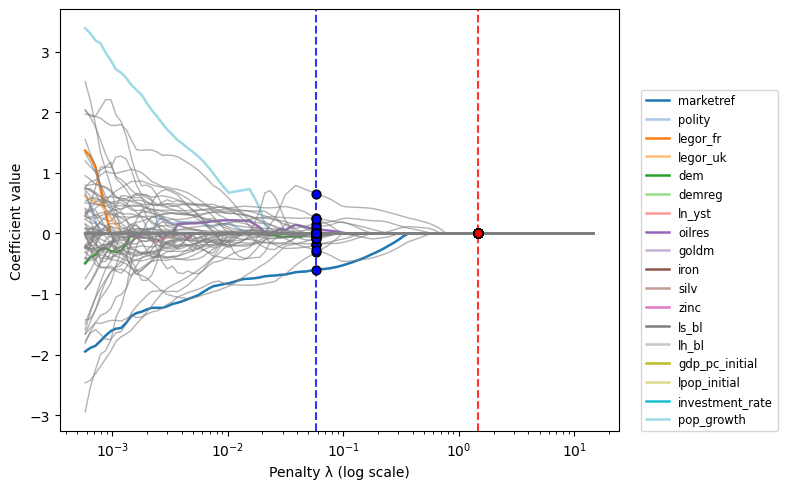

In [ ]:
#Plot with CV and BCCH
lambda_grid, coefs, vlines = a2.lasso_path_plot(
    X=X_stan,
    y=g_LR,
    feature_names=feature_names,          
    main_feature_names=main_feature_names,
    penalty_methods={"BCCH": a2.BCCH, "CV": a2.CV}
)